### E. Clothing Classification
Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples
and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from
10 classes. One can design a convolutional neural network or Transformer to address the classification
problem.

#### Some tasks to consider:
1. Modify some previously published architectures e.g., increase the network depth, reducing their
parameters, etc. Explore more dilated techniques such as deformable convolution, dilated
convolution (dilation>1) or visual prompt tuning for Transformers.
2. Use more dilated transformation techniques such as MixUp (see the original paper and its
PyTorch implementation here)
3. Comparing the performance of different network architectures

#### References:
- [Deep Learning CNN for Fashion-MNIST Clothing Classification](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/)

#### Datasets:
- [Dataset available in TorchVision](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)


# Initializing the Environment

In [1]:
# Install required packages (Run only once)
! pip install torch torchvision matplotlib scikit-learn seaborn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.2 MB/s eta 0:00:00


## Import libraries


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from torchvision import datasets, transforms
from torchvision.ops import DeformConv2d
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from tabulate import tabulate

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Define Global Hyperparameters

In [4]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 50

# 📥 Loading and Preparing the Fashion-MNIST Dataset


We load the **Fashion-MNIST** dataset using `torchvision.datasets`, which contains 60,000 training images and 10,000 test images of 28×28 grayscale clothing items across 10 categories.

#### 🧹 Preprocessing Steps:
- **`ToTensor()`**: Converts images from PIL format to PyTorch tensors and scales pixel values from [0, 255] to [0.0, 1.0].
- **`Normalize((0.5,), (0.5,))`**: Normalizes the images by shifting the mean to 0 and scaling them to [-1, 1].

#### 🔄 Dataloaders:
- **Training DataLoader** (`shuffle=True`): Randomly shuffles training images for better generalization.
- **Test DataLoader** (`shuffle=False`): Keeps test data in order for consistent evaluation.

The `classes` list maps numerical labels (0–9) to their corresponding class names:
```python
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [5]:
# Define transformations for the dataset
transform = transforms.Compose([
   transforms.ToTensor(),  # Convert PIL images to tensors
   transforms.Normalize((0.5,), (0.5,))  # Normalize with mean=0.5 and std=0.5
])

In [6]:
# Load the training dataset
train_dataset = datasets.FashionMNIST(
   root='./data',  # Directory to store the dataset
   train=True,  # Load training data
   transform=transform,  # Apply transformations
   download=True  # Download the dataset if not already present
)

# Load the test dataset
test_dataset = datasets.FashionMNIST(
   root='./data',
   train=False,  # Load test data
   transform=transform,
   download=True
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.87MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 24.8MB/s]


In [7]:
# Create DataLoaders for batching
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

In [8]:
# print dataset information
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 60000
Number of test samples: 10000


In [9]:
classes = train_dataset.classes
print(classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


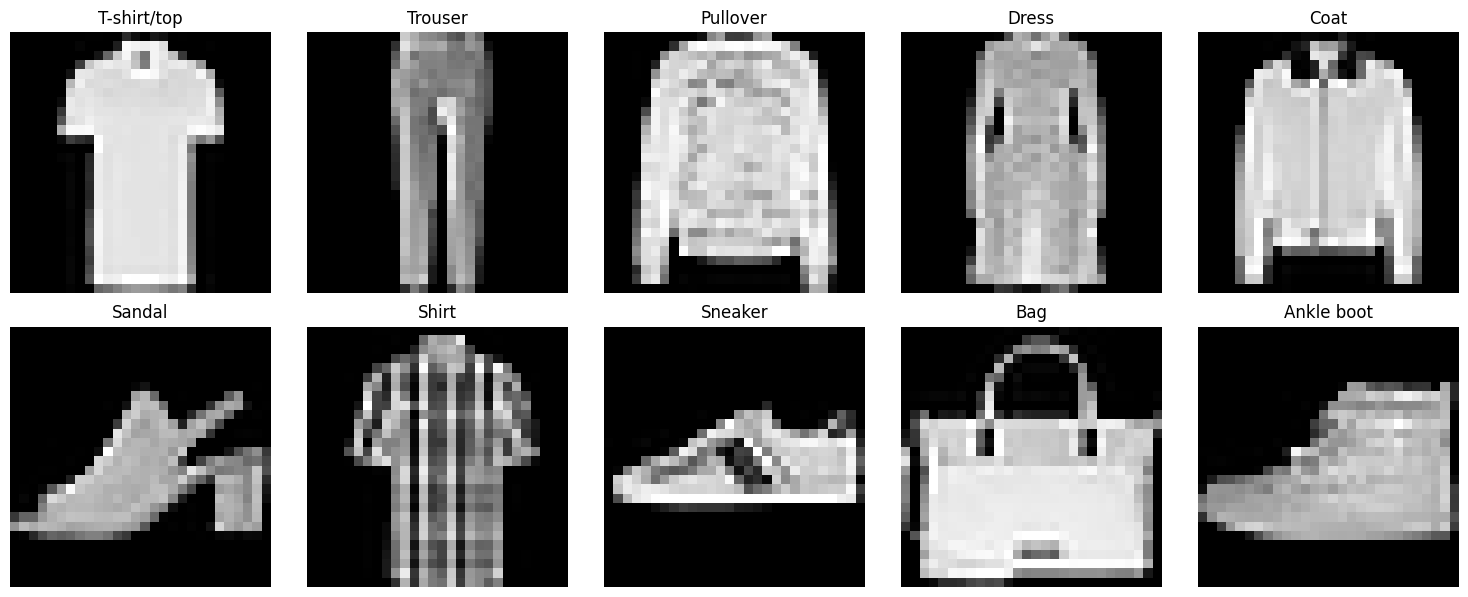

In [10]:
# Show a sample image from each class in the dataset.
def show_images(images, labels, classes, grid_size=(3, 5), figsize=(15, 9)):
    # Prepare a dictionary to store one sample from each class
    class_samples = {i: None for i in range(len(classes))}

    # Collect one sample image per class
    for img, label in zip(images, labels):
        if class_samples[label.item()] is None:
            class_samples[label.item()] = img.squeeze()  # Store the image, remove channel dimension

    # Prepare to plot the collected samples
    plt.figure(figsize=figsize)
    for class_id, img in class_samples.items():
        if img is not None:  # Only plot if we have an image for the class
            plt.subplot(grid_size[0], grid_size[1], class_id + 1)
            plt.imshow(img, cmap='gray')
            plt.title(classes[class_id])
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show one image from each class
show_images(images, labels, classes)

# Implementation of different architectures

## Standard CNN with 2 Convolutional Layer

In [11]:
# A standard CNN model with 2 Convolutional layer
class StandardCNN(nn.Module):
    def __init__(self):
        super(StandardCNN, self).__init__()

        # Convolutional layer 1: Input channels = 1, Output channels = 32
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)

        # Convolutional layer 2: Input channels = 32, Output channels = 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Pooling reduces spatial dimensions by 2

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Flattened size after pooling
        self.fc2 = nn.Linear(128, 10)  # Output layer for 10 classes

    def forward(self, x):
        # Forward pass through the first convolutional layer and pooling
        x = self.pool(nn.functional.relu(self.conv1(x)))    # 28x28 -> 14x14

        # Forward pass through the second convolutional layer and pooling
        x = self.pool(nn.functional.relu(self.conv2(x)))    # 14x14 -> 7x7

        # Flatten the output for the fully connected layers
        x = x.view(-1, 64 * 7 * 7)

        # Forward pass through the first fully connected layer
        x = nn.functional.relu(self.fc1(x))

        # Forward pass through the output layer
        x = self.fc2(x)

        return x

## Deep CNN with 4 Convolutional Layer

In [12]:
# A Deep CNN model with 4 convolutional layer
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()

        # First convolutional layer: Input channels = 1, Output channels = 32
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)

        # Second convolutional layer: Input channels = 32, Output channels = 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Third convolutional layer: Input channels = 64, Output channels = 128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Fourth convolutional layer: Input channels = 128, Output channels = 256
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling reduces spatial dimensions by 2

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 1 * 1, 512)  # Flattened size after pooling
        self.fc2 = nn.Linear(512, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x))) # 28x28 -> 14x14
        x = self.pool(nn.functional.relu(self.conv2(x))) # 14x14 -> 7x7
        x = self.pool(nn.functional.relu(self.conv3(x))) # 7x7 -> 3x3
        x = self.pool(nn.functional.relu(self.conv4(x))) # 3x3 -> 1x1
        x = x.view(-1, 256 * 1 * 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## Standard CNN with Dilation

In [13]:
# A standard CNN model with 2 Convolutional layers applied with dilation
class DilatedCNN(nn.Module):
    def __init__(self, dilation_val=1):
        super(DilatedCNN, self).__init__()  # Corrected the class name here

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)

        # Dilation allows for an increased receptive field without increasing the kernel size
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=dilation_val, dilation=dilation_val)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling reduces spatial dimensions by 2

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Flattened size after pooling
        self.fc2 = nn.Linear(128, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x))) # 28x28 -> 14x14
        x = self.pool(nn.functional.relu(self.conv2(x))) # 14x14 -> 7x7
        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## Deformable CNN with 2 Layers


In [14]:
# A Deformable CNN model with 2 Deformable Convolutional layers
class DeformableCNN(nn.Module):
    def __init__(self):
        super(DeformableCNN, self).__init__()

        # Deformable Convolutional Layer 1: Input channels = 1, Output channels = 32
        self.offsets1 = nn.Conv2d(1, 18, kernel_size=3, stride=1, padding=1)  # Offsets for deformable conv1
        self.deform_conv1 = DeformConv2d(1, 32, kernel_size=3, stride=1, padding=1)

        # Deformable Convolutional Layer 2: Input channels = 32, Output channels = 64
        self.offsets2 = nn.Conv2d(32, 18, kernel_size=3, stride=1, padding=1)  # Offsets for deformable conv2
        self.deform_conv2 = DeformConv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling reduces spatial dimensions by 2

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Flattened size after pooling
        self.fc2 = nn.Linear(128, 10)  # Output layer for 10 classes

    def forward(self, x):
        # Deformable Convolution 1
        offsets1 = self.offsets1(x)  # Learnable offsets for deformable convolution
        x = self.deform_conv1(x, offsets1)  # Apply deformable convolution
        x = nn.functional.relu(x)  # Activation
        x = self.pool(x)  # 28x28 -> 14x14

        # Deformable Convolution 2
        offsets2 = self.offsets2(x)  # Learnable offsets for deformable convolution
        x = self.deform_conv2(x, offsets2)  # Apply deformable convolution
        x = nn.functional.relu(x)  # Activation
        x = self.pool(x)  # 14x14 -> 7x7

        # Flatten the output for the fully connected layers
        x = x.view(-1, 64 * 7 * 7)

        # Fully connected layers
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## Enhanced Deformable CNN with Regularization and Normalization

In [15]:
# An Enhanced Deformable CNN model that integrates regularization and normalization
class EnahncedDeformableCNN(nn.Module):
    def __init__(self, dropout_val=0.3):
        super(EnahncedDeformableCNN, self).__init__()

        # Deformable Convolutional Layer 1: Input channels = 1, Output channels = 32
        self.offsets1 = nn.Conv2d(1, 18, kernel_size=3, stride=1, padding=1)  # Offsets for deformable conv1
        self.deform_conv1 = DeformConv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)  # BatchNorm for deformable conv1

        # Deformable Convolutional Layer 2: Input channels = 32, Output channels = 64
        self.offsets2 = nn.Conv2d(32, 18, kernel_size=3, stride=1, padding=1)  # Offsets for deformable conv2
        self.deform_conv2 = DeformConv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)  # BatchNorm for deformable conv2

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling reduces spatial dimensions by 2

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Flattened size after pooling
        self.dropout1 = nn.Dropout(p=dropout_val)  # Dropout for fc1
        self.fc2 = nn.Linear(128, 10)  # Output layer for 10 classes
        self.dropout2 = nn.Dropout(p=dropout_val)  # Dropout for fc2

    def forward(self, x):
        # Deformable Convolution 1
        offsets1 = self.offsets1(x)  # Learnable offsets for deformable convolution
        x = self.deform_conv1(x, offsets1)  # Apply deformable convolution
        x = self.batchnorm1(x)  # Apply BatchNorm
        x = nn.functional.relu(x)  # Activation
        x = self.pool(x)  # 28x28 -> 14x14

        # Deformable Convolution 2
        offsets2 = self.offsets2(x)  # Learnable offsets for deformable convolution
        x = self.deform_conv2(x, offsets2)  # Apply deformable convolution
        x = self.batchnorm2(x)  # Apply BatchNorm
        x = nn.functional.relu(x)  # Activation
        x = self.pool(x)  # 14x14 -> 7x7

        # Flatten the output for the fully connected layers
        x = x.view(-1, 64 * 7 * 7)

        # Fully connected layers with Dropout
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply Dropout after fc1
        x = self.fc2(x)
        x = self.dropout2(x)  # Apply Dropout after fc2 (optional)

        return x

# Training and Validating the different architectures


In [16]:
def train_and_validate_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, model_name, patience=10):
    model.train()
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    best_val_loss = float('inf')  # Initialize best validation loss
    epochs_without_improvement = 0  # Counter for early stopping

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(test_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'{model_name} - Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss  # Update best validation loss
            epochs_without_improvement = 0  # Reset counter
            # Save the model
            # torch.save(model.state_dict(), f'{model_name}_best.pth')
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs without improvement.')
            break

    return train_losses, train_accs, val_losses, val_accs

In [17]:
# Initialize criterion using Cross Entropy method
criterion = nn.CrossEntropyLoss()

## Training Standard Model

In [18]:
# Initialize the model
standard_model = StandardCNN().to(device)

# Initialize the optimizer using Adam optimizer
optimizer_standard = torch.optim.Adam(standard_model.parameters(), lr=LEARNING_RATE)

In [19]:
standard_train_loss, standard_train_acc, standard_val_loss, standard_val_acc = train_and_validate_model(
   standard_model, train_loader, test_loader, criterion, optimizer_standard, NUM_EPOCHS, "Standard CNN")

# # Save the results to a .npy file
# np.savez('standard_cnn_results.npz',
#          train_loss=standard_train_loss,
#          train_acc=standard_train_acc,
#          val_loss=standard_val_loss,
#          val_acc=standard_val_acc)

Standard CNN - Epoch [1/50], Train Loss: 0.4273, Train Acc: 84.60%, Val Loss: 0.3234, Val Acc: 88.56%
Standard CNN - Epoch [2/50], Train Loss: 0.2724, Train Acc: 90.07%, Val Loss: 0.2702, Val Acc: 89.92%
Standard CNN - Epoch [3/50], Train Loss: 0.2232, Train Acc: 91.92%, Val Loss: 0.2449, Val Acc: 91.34%
Standard CNN - Epoch [4/50], Train Loss: 0.1932, Train Acc: 92.90%, Val Loss: 0.2377, Val Acc: 91.22%
Standard CNN - Epoch [5/50], Train Loss: 0.1668, Train Acc: 93.92%, Val Loss: 0.2253, Val Acc: 92.09%
Standard CNN - Epoch [6/50], Train Loss: 0.1445, Train Acc: 94.69%, Val Loss: 0.2419, Val Acc: 91.75%
Standard CNN - Epoch [7/50], Train Loss: 0.1229, Train Acc: 95.45%, Val Loss: 0.2349, Val Acc: 91.95%
Standard CNN - Epoch [8/50], Train Loss: 0.1057, Train Acc: 96.09%, Val Loss: 0.2373, Val Acc: 92.30%
Standard CNN - Epoch [9/50], Train Loss: 0.0894, Train Acc: 96.71%, Val Loss: 0.3027, Val Acc: 91.36%
Standard CNN - Epoch [10/50], Train Loss: 0.0752, Train Acc: 97.24%, Val Loss: 0.2

## Training Deep Model

In [20]:
# Initialize the model
deep_model = DeepCNN().to(device)

# Initialize the optimizer using Adam optimizer
optimizer_deep = torch.optim.Adam(deep_model.parameters(), lr=LEARNING_RATE)

In [21]:
deep_train_loss, deep_train_acc, deep_val_loss, deep_val_acc = train_and_validate_model(
   deep_model, train_loader, test_loader, criterion, optimizer_deep, NUM_EPOCHS, "Deep CNN")

# # Save the results to a .npy file
# np.savez('deep_cnn_results.npz',
#          train_loss=deep_train_loss,
#          train_acc=deep_train_acc,
#          val_loss=deep_val_loss,
#          val_acc=deep_val_acc)

Deep CNN - Epoch [1/50], Train Loss: 0.4836, Train Acc: 82.10%, Val Loss: 0.3531, Val Acc: 86.89%
Deep CNN - Epoch [2/50], Train Loss: 0.2876, Train Acc: 89.45%, Val Loss: 0.3025, Val Acc: 88.99%
Deep CNN - Epoch [3/50], Train Loss: 0.2414, Train Acc: 91.04%, Val Loss: 0.2547, Val Acc: 90.90%
Deep CNN - Epoch [4/50], Train Loss: 0.2104, Train Acc: 92.27%, Val Loss: 0.2670, Val Acc: 90.75%
Deep CNN - Epoch [5/50], Train Loss: 0.1848, Train Acc: 93.06%, Val Loss: 0.2456, Val Acc: 90.94%
Deep CNN - Epoch [6/50], Train Loss: 0.1623, Train Acc: 94.00%, Val Loss: 0.2618, Val Acc: 91.36%
Deep CNN - Epoch [7/50], Train Loss: 0.1432, Train Acc: 94.74%, Val Loss: 0.2547, Val Acc: 91.69%
Deep CNN - Epoch [8/50], Train Loss: 0.1258, Train Acc: 95.32%, Val Loss: 0.2716, Val Acc: 91.44%
Deep CNN - Epoch [9/50], Train Loss: 0.1100, Train Acc: 95.93%, Val Loss: 0.2865, Val Acc: 91.82%
Deep CNN - Epoch [10/50], Train Loss: 0.0957, Train Acc: 96.33%, Val Loss: 0.2843, Val Acc: 91.11%
Deep CNN - Epoch [1

## Training Dilated Model

In [22]:
# Initialize the model
dilated_low_model = DilatedCNN(2).to(device)

# Initialize the optimizer using Adam optimizer
optimizer_dilated = torch.optim.Adam(dilated_low_model.parameters(), lr=LEARNING_RATE)

In [23]:
dilated_low_train_loss, dilated_low_train_acc, dilated_low_val_loss, dilated_low_val_acc = train_and_validate_model(
   dilated_low_model, train_loader, test_loader, criterion, optimizer_dilated, NUM_EPOCHS, "Dilated(Low) CNN")

# # Save the results to a .npy file
# np.savez('dilated_low_cnn_results.npz',
#          train_loss=dilated_low_train_loss,
#          train_acc=dilated_low_train_acc,
#          val_loss=dilated_low_val_loss,
#          val_acc=dilated_low_val_acc)

Dilated(Low) CNN - Epoch [1/50], Train Loss: 0.4506, Train Acc: 83.62%, Val Loss: 0.3447, Val Acc: 87.36%
Dilated(Low) CNN - Epoch [2/50], Train Loss: 0.2831, Train Acc: 89.80%, Val Loss: 0.2811, Val Acc: 89.77%
Dilated(Low) CNN - Epoch [3/50], Train Loss: 0.2350, Train Acc: 91.35%, Val Loss: 0.2624, Val Acc: 90.26%
Dilated(Low) CNN - Epoch [4/50], Train Loss: 0.2051, Train Acc: 92.36%, Val Loss: 0.2464, Val Acc: 91.27%
Dilated(Low) CNN - Epoch [5/50], Train Loss: 0.1758, Train Acc: 93.47%, Val Loss: 0.2748, Val Acc: 90.62%
Dilated(Low) CNN - Epoch [6/50], Train Loss: 0.1542, Train Acc: 94.29%, Val Loss: 0.2257, Val Acc: 91.90%
Dilated(Low) CNN - Epoch [7/50], Train Loss: 0.1333, Train Acc: 95.05%, Val Loss: 0.2589, Val Acc: 91.22%
Dilated(Low) CNN - Epoch [8/50], Train Loss: 0.1150, Train Acc: 95.73%, Val Loss: 0.2609, Val Acc: 91.43%
Dilated(Low) CNN - Epoch [9/50], Train Loss: 0.0971, Train Acc: 96.31%, Val Loss: 0.2986, Val Acc: 91.08%
Dilated(Low) CNN - Epoch [10/50], Train Loss: 

In [24]:
# Initialize the model
dilated_high_model = DilatedCNN(10).to(device)

# Initialize the optimizer using Adam optimizer
optimizer_dilated = torch.optim.Adam(dilated_high_model.parameters(), lr=LEARNING_RATE)

In [25]:
dilated_high_train_loss, dilated_high_train_acc, dilated_high_val_loss, dilated_high_val_acc = train_and_validate_model(
   dilated_high_model, train_loader, test_loader, criterion, optimizer_dilated, NUM_EPOCHS, "Dilated(High) CNN")

# # Save the results to a .npy file
# np.savez('dilated_high_cnn_results.npz',
#          train_loss=dilated_high_train_loss,
#          train_acc=dilated_high_train_acc,
#          val_loss=dilated_high_val_loss,
#          val_acc=dilated_high_val_acc)

Dilated(High) CNN - Epoch [1/50], Train Loss: 0.4736, Train Acc: 83.09%, Val Loss: 0.3755, Val Acc: 86.59%
Dilated(High) CNN - Epoch [2/50], Train Loss: 0.3120, Train Acc: 88.64%, Val Loss: 0.3272, Val Acc: 87.77%
Dilated(High) CNN - Epoch [3/50], Train Loss: 0.2661, Train Acc: 90.24%, Val Loss: 0.2903, Val Acc: 89.72%
Dilated(High) CNN - Epoch [4/50], Train Loss: 0.2383, Train Acc: 91.19%, Val Loss: 0.2758, Val Acc: 90.28%
Dilated(High) CNN - Epoch [5/50], Train Loss: 0.2134, Train Acc: 92.02%, Val Loss: 0.2576, Val Acc: 90.75%
Dilated(High) CNN - Epoch [6/50], Train Loss: 0.1905, Train Acc: 92.98%, Val Loss: 0.2612, Val Acc: 90.78%
Dilated(High) CNN - Epoch [7/50], Train Loss: 0.1689, Train Acc: 93.70%, Val Loss: 0.2584, Val Acc: 90.97%
Dilated(High) CNN - Epoch [8/50], Train Loss: 0.1547, Train Acc: 94.25%, Val Loss: 0.2467, Val Acc: 91.74%
Dilated(High) CNN - Epoch [9/50], Train Loss: 0.1364, Train Acc: 94.98%, Val Loss: 0.2544, Val Acc: 91.44%
Dilated(High) CNN - Epoch [10/50], Tr

## Training Deformable Model

In [26]:
# Initialize the model
deform_model = DeformableCNN().to(device)

# Initialize the optimizer using Adam optimizer
optimizer_deform = torch.optim.Adam(deform_model.parameters(), lr=LEARNING_RATE)

In [27]:
deform_train_loss, deform_train_acc, deform_val_loss, deform_val_acc = train_and_validate_model(
   deform_model, train_loader, test_loader, criterion, optimizer_deform, NUM_EPOCHS, "Deform CNN")

# # Save the results to a .npy file
# np.savez('deform_cnn_results.npz',
#          train_loss=deform_train_loss,
#          train_acc=deform_train_acc,
#          val_loss=deform_val_loss,
#          val_acc=deform_val_acc)

Deform CNN - Epoch [1/50], Train Loss: 0.4525, Train Acc: 83.58%, Val Loss: 0.3676, Val Acc: 85.88%
Deform CNN - Epoch [2/50], Train Loss: 0.2906, Train Acc: 89.33%, Val Loss: 0.2844, Val Acc: 89.74%
Deform CNN - Epoch [3/50], Train Loss: 0.2421, Train Acc: 91.22%, Val Loss: 0.2959, Val Acc: 89.45%
Deform CNN - Epoch [4/50], Train Loss: 0.2159, Train Acc: 92.07%, Val Loss: 0.2359, Val Acc: 91.53%
Deform CNN - Epoch [5/50], Train Loss: 0.1923, Train Acc: 92.90%, Val Loss: 0.2460, Val Acc: 91.17%
Deform CNN - Epoch [6/50], Train Loss: 0.1735, Train Acc: 93.62%, Val Loss: 0.2395, Val Acc: 91.43%
Deform CNN - Epoch [7/50], Train Loss: 0.1534, Train Acc: 94.35%, Val Loss: 0.2386, Val Acc: 91.94%
Deform CNN - Epoch [8/50], Train Loss: 0.1375, Train Acc: 94.86%, Val Loss: 0.2386, Val Acc: 91.96%
Deform CNN - Epoch [9/50], Train Loss: 0.1218, Train Acc: 95.40%, Val Loss: 0.2525, Val Acc: 91.72%
Deform CNN - Epoch [10/50], Train Loss: 0.1090, Train Acc: 95.89%, Val Loss: 0.2498, Val Acc: 91.75%

## Training Deformable Model with Regularization and Normalization

In [28]:
# Initialize the model
enhanced_deform_model = EnahncedDeformableCNN().to(device)

# Initialize the optimizer using Adam optimizer
optimizer_enhanced_deform = torch.optim.Adam(enhanced_deform_model.parameters(), lr=LEARNING_RATE)

In [29]:
enhanced_deform_train_loss, enhanced_deform_train_acc, enhanced_deform_val_loss, enhanced_deform_val_acc = train_and_validate_model(
   enhanced_deform_model, train_loader, test_loader, criterion, optimizer_enhanced_deform, NUM_EPOCHS, "Enhanced Deform CNN")

# # Save the results to a .npy file
# np.savez('enhanced_deform_cnn_results.npz',
#          train_loss=enhanced_deform_train_loss,
#          train_acc=enhanced_deform_train_acc,
#          val_loss=enhanced_deform_val_loss,
#          val_acc=enhanced_deform_val_acc)

Enhanced Deform CNN - Epoch [1/50], Train Loss: 0.8772, Train Acc: 65.48%, Val Loss: 0.3794, Val Acc: 85.94%
Enhanced Deform CNN - Epoch [2/50], Train Loss: 0.7272, Train Acc: 69.88%, Val Loss: 0.3234, Val Acc: 88.47%
Enhanced Deform CNN - Epoch [3/50], Train Loss: 0.6880, Train Acc: 70.81%, Val Loss: 0.2787, Val Acc: 89.82%
Enhanced Deform CNN - Epoch [4/50], Train Loss: 0.6685, Train Acc: 71.31%, Val Loss: 0.2828, Val Acc: 90.21%
Enhanced Deform CNN - Epoch [5/50], Train Loss: 0.6442, Train Acc: 72.06%, Val Loss: 0.2656, Val Acc: 90.15%
Enhanced Deform CNN - Epoch [6/50], Train Loss: 0.6255, Train Acc: 72.81%, Val Loss: 0.2555, Val Acc: 90.87%
Enhanced Deform CNN - Epoch [7/50], Train Loss: 0.6101, Train Acc: 73.06%, Val Loss: 0.2451, Val Acc: 91.30%
Enhanced Deform CNN - Epoch [8/50], Train Loss: 0.6006, Train Acc: 73.37%, Val Loss: 0.2481, Val Acc: 90.86%
Enhanced Deform CNN - Epoch [9/50], Train Loss: 0.5898, Train Acc: 73.45%, Val Loss: 0.2448, Val Acc: 91.35%
Enhanced Deform CNN

# Data Augmentation using MixUp


In [30]:
# Applies MixUp to a batch of inputs and their labels.
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = torch.distributions.Beta(alpha, alpha).sample().item()
    else:
        lam = 1.0

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)  # Shuffle indices

    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_y = lam * y + (1 - lam) * y[index]

    return mixed_x, mixed_y, lam

In [31]:
# Train the model with MixUp augmentation
def train_with_mixup(model, train_loader, test_loader, criterion, optimizer, num_epochs, model_name, alpha=0.3, patience=10):
    model.train()
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    best_val_loss = float('inf')  # Initialize best validation loss
    epochs_without_improvement = 0  # Counter for early stopping

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Convert labels to one-hot encoding for MixUp
            labels_onehot = nn.functional.one_hot(labels, num_classes=10).float()

            # Apply MixUp augmentation
            images, labels_mixed, _ = mixup_data(images, labels_onehot, alpha)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels_mixed)  # MixUp uses BCEWithLogitsLoss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)

            # For MixUp, accuracy here is not entirely valid because labels are mixed.
            # However, we can still compare the raw predictions with the primary labels
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, nn.functional.one_hot(labels, num_classes=10).float())
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(test_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'{model_name} - Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss  # Update best validation loss
            epochs_without_improvement = 0  # Reset counter
            # Save the best model
            # torch.save(model.state_dict(), f'{model_name}_best.pth')
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs without improvement.")
            break

    return train_losses, train_accs, val_losses, val_accs

In [32]:
# Define the criterion (use BCEWithLogitsLoss for mixed labels)
criterion_mixup = nn.BCEWithLogitsLoss()  # Handles non one-hot labels

## Training Standard Model with MixUp data

In [33]:
# Initialize the model
mixup_standard_model = StandardCNN().to(device)

# Initialize the optimizer
mixup_standard_optimizer = torch.optim.Adam(mixup_standard_model.parameters(), lr=LEARNING_RATE)

mixup_standard_train_loss, mixup_standard_train_acc, mixup_standard_val_loss, mixup_standard_val_acc = train_with_mixup(
    mixup_standard_model, train_loader, test_loader, criterion_mixup, mixup_standard_optimizer, NUM_EPOCHS, "Standard CNN with MixUp")

# # Save the results to a .npy file
# np.savez('mixup_standard_cnn_results.npz',
#          train_loss=mixup_standard_train_loss,
#          train_acc=mixup_standard_train_acc,
#          val_loss=mixup_standard_val_loss,
#          val_acc=mixup_standard_val_acc)

Standard CNN with MixUp - Epoch [1/50], Train Loss: 0.1431, Train Acc: 47.68%, Val Loss: 0.0680, Val Acc: 87.38%
Standard CNN with MixUp - Epoch [2/50], Train Loss: 0.1147, Train Acc: 52.80%, Val Loss: 0.0573, Val Acc: 89.39%
Standard CNN with MixUp - Epoch [3/50], Train Loss: 0.1060, Train Acc: 50.24%, Val Loss: 0.0527, Val Acc: 90.48%
Standard CNN with MixUp - Epoch [4/50], Train Loss: 0.0998, Train Acc: 52.86%, Val Loss: 0.0485, Val Acc: 91.25%
Standard CNN with MixUp - Epoch [5/50], Train Loss: 0.0958, Train Acc: 49.35%, Val Loss: 0.0481, Val Acc: 91.09%
Standard CNN with MixUp - Epoch [6/50], Train Loss: 0.0940, Train Acc: 51.15%, Val Loss: 0.0456, Val Acc: 91.50%
Standard CNN with MixUp - Epoch [7/50], Train Loss: 0.0942, Train Acc: 53.87%, Val Loss: 0.0430, Val Acc: 91.80%
Standard CNN with MixUp - Epoch [8/50], Train Loss: 0.0908, Train Acc: 50.02%, Val Loss: 0.0432, Val Acc: 91.92%
Standard CNN with MixUp - Epoch [9/50], Train Loss: 0.0897, Train Acc: 52.89%, Val Loss: 0.0414,

## Training Deformable Model with MixUp

In [48]:
# Initialize the model
mixup_deform_model = DeformableCNN().to(device)

# Initialize the optimizer
mixup_deform_optimizer = torch.optim.Adam(mixup_deform_model.parameters(), lr=LEARNING_RATE)

mixup_deform_train_loss, mixup_deform_train_acc, mixup_deform_val_loss, mixup_deform_val_acc = train_with_mixup(
    mixup_deform_model, train_loader, test_loader, criterion_mixup, mixup_deform_optimizer, NUM_EPOCHS, "Deform CNN with MixUp")

# # Save the results to a .npy file
# np.savez('mixup_deform_cnn_results.npz',
#          train_loss=mixup_deform_train_loss,
#          train_acc=mixup_deform_train_acc,
#          val_loss=mixup_deform_val_loss,
#          val_acc=mixup_deform_val_acc)

Deform CNN with MixUp - Epoch [1/50], Train Loss: 0.1436, Train Acc: 45.34%, Val Loss: 0.0702, Val Acc: 86.61%
Deform CNN with MixUp - Epoch [2/50], Train Loss: 0.1136, Train Acc: 53.88%, Val Loss: 0.0601, Val Acc: 88.79%
Deform CNN with MixUp - Epoch [3/50], Train Loss: 0.1087, Train Acc: 51.34%, Val Loss: 0.0541, Val Acc: 89.71%
Deform CNN with MixUp - Epoch [4/50], Train Loss: 0.1052, Train Acc: 51.33%, Val Loss: 0.0523, Val Acc: 90.31%
Deform CNN with MixUp - Epoch [5/50], Train Loss: 0.0976, Train Acc: 53.27%, Val Loss: 0.0468, Val Acc: 91.20%
Deform CNN with MixUp - Epoch [6/50], Train Loss: 0.0984, Train Acc: 52.99%, Val Loss: 0.0477, Val Acc: 91.05%
Deform CNN with MixUp - Epoch [7/50], Train Loss: 0.0920, Train Acc: 52.21%, Val Loss: 0.0454, Val Acc: 91.95%
Deform CNN with MixUp - Epoch [8/50], Train Loss: 0.0927, Train Acc: 51.90%, Val Loss: 0.0441, Val Acc: 91.62%
Deform CNN with MixUp - Epoch [9/50], Train Loss: 0.0933, Train Acc: 53.73%, Val Loss: 0.0434, Val Acc: 92.16%
D

# Results and Analysis

In [49]:
# Find the best validation accuracy and corresponding epoch for each model
best_standard_val_acc = max(standard_val_acc)
best_standard_epoch = standard_val_acc.index(best_standard_val_acc) + 1

best_deep_val_acc = max(deep_val_acc)
best_deep_epoch = deep_val_acc.index(best_deep_val_acc) + 1

best_dilated_low_val_acc = max(dilated_low_val_acc)
best_dilated_low_epoch = dilated_low_val_acc.index(best_dilated_low_val_acc) + 1

best_dilated_high_val_acc = max(dilated_high_val_acc)
best_dilated_high_epoch = dilated_high_val_acc.index(best_dilated_high_val_acc) + 1

best_deform_val_acc = max(deform_val_acc)
best_deform_epoch = deform_val_acc.index(best_deform_val_acc) + 1

best_enhanced_deform_val_acc = max(enhanced_deform_val_acc)
best_enhanced_deform_epoch = enhanced_deform_val_acc.index(best_enhanced_deform_val_acc) + 1

best_mixup_standard_val_acc = max(mixup_standard_val_acc)
best_mixup_standard_epoch = mixup_standard_val_acc.index(best_mixup_standard_val_acc) + 1

best_mixup_deform_val_acc = max(mixup_deform_val_acc)
best_mixup_deform_epoch = mixup_deform_val_acc.index(best_mixup_deform_val_acc) + 1

results = [
    ["Standard CNN", f"{best_standard_val_acc:.2f}%", best_standard_epoch],
    ["Deep CNN", f"{best_deep_val_acc:.2f}%", best_deep_epoch],
    ["Dilated(Low) CNN", f"{best_dilated_low_val_acc:.2f}%", best_dilated_low_epoch],
    ["Dilated(High) CNN", f"{best_dilated_high_val_acc:.2f}%", best_dilated_high_epoch],
    ["Deformable CNN", f"{best_deform_val_acc:.2f}%", best_deform_epoch],
    ["Enhanced Deformable CNN", f"{best_enhanced_deform_val_acc:.2f}%", best_enhanced_deform_epoch],
    ["Standard CNN with MixUp", f"{best_mixup_standard_val_acc:.2f}%", best_mixup_standard_epoch],
    ["Deformable CNN with MixUp", f"{best_mixup_deform_val_acc:.2f}%", best_mixup_deform_epoch]
]

headers = ["Model", "Best Validation Accuracy", "Epoch"]
print(tabulate(results, headers=headers, tablefmt="grid"))

+---------------------------+----------------------------+---------+
| Model                     | Best Validation Accuracy   |   Epoch |
+===========================+============================+=========+
| Standard CNN              | 92.30%                     |       8 |
+---------------------------+----------------------------+---------+
| Deep CNN                  | 91.94%                     |      11 |
+---------------------------+----------------------------+---------+
| Dilated(Low) CNN          | 91.91%                     |      12 |
+---------------------------+----------------------------+---------+
| Dilated(High) CNN         | 91.88%                     |      14 |
+---------------------------+----------------------------+---------+
| Deformable CNN            | 92.20%                     |      13 |
+---------------------------+----------------------------+---------+
| Enhanced Deformable CNN   | 92.20%                     |      18 |
+---------------------------+-----

In [50]:
# Plots epoch to metric for multiple models, handling variable epoch lengths.
def plot_epoch_to_metric(metrics_array, model_names, metric_name="Accuracy"):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))

    # Find the maximum epochs across all models
    max_epochs = max(len(metrics) for metrics in metrics_array)

    # Iterate through each model's metrics and plot
    for model_metrics, model_name in zip(metrics_array, model_names):
        epochs = range(1, len(model_metrics) + 1)  # Generate epoch numbers for the given metrics
        plt.plot(epochs, model_metrics, label=model_name)

    # Add labels, title, and legend
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name}")
    plt.legend()
    plt.grid(True)

    # Set x-axis ticks to always start at 1 and increment by 1
    plt.xticks(range(1, max_epochs + 1, 1))

    plt.tight_layout()

    # Show the plot
    plt.show()

## Validation Accuracy Comparison

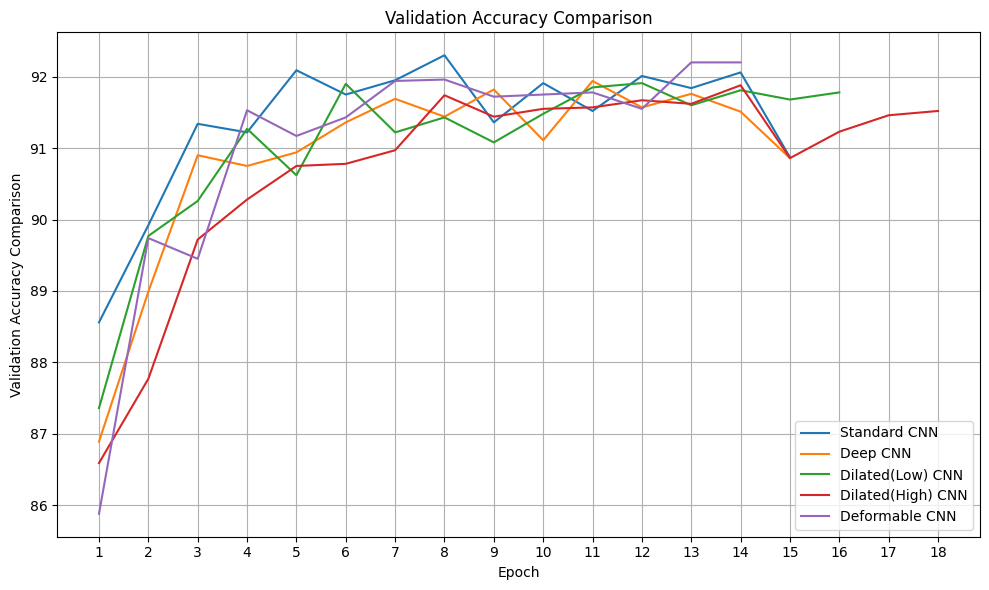

In [51]:
plot_epoch_to_metric(
    [standard_val_acc, deep_val_acc, dilated_low_val_acc, dilated_high_val_acc, deform_val_acc],
     ["Standard CNN", "Deep CNN", "Dilated(Low) CNN", "Dilated(High) CNN", "Deformable CNN"],
    "Validation Accuracy Comparison")

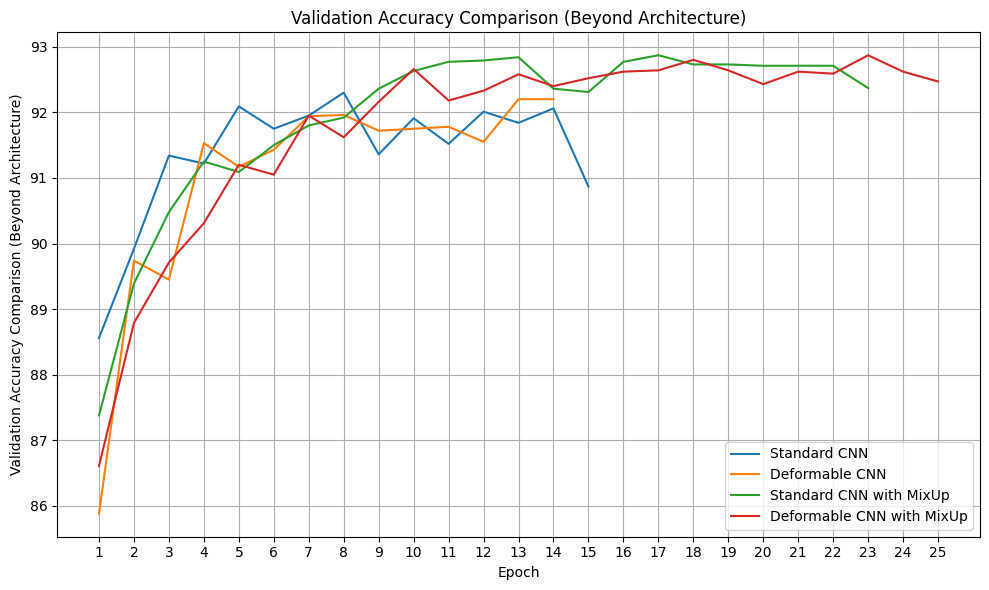

In [67]:
plot_epoch_to_metric(
    [standard_val_acc, deform_val_acc, mixup_standard_val_acc, mixup_deform_val_acc],
     ["Standard CNN", "Deformable CNN", "Standard CNN with MixUp", "Deformable CNN with MixUp"],
    "Validation Accuracy Comparison (Beyond Architecture)")

## Evaluation of each Architecture


In [53]:
def plot_confusion_matrix_enhanced(model, test_loader, model_name):
   model.eval()
   all_preds = []
   all_labels = []

   with torch.no_grad():
       for images, labels in test_loader:
           images = images.to(device)
           labels = labels.to(device)
           outputs = model(images)
           _, preds = torch.max(outputs, 1)
           all_preds.extend(preds.cpu().numpy())
           all_labels.extend(labels.cpu().numpy())

   # Compute confusion matrix
   cm = confusion_matrix(all_labels, all_preds)
   cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

   # Plot
   plt.figure(figsize=(12, 10))

   # Plot counts
   plt.subplot(2, 1, 1)
   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=classes, yticklabels=classes)
   plt.title(f'Confusion Matrix (Counts) - {model_name}')
   plt.xlabel('Predicted')
   plt.ylabel('True')

   # Plot percentages
   plt.subplot(2, 1, 2)
   sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens',
               xticklabels=classes, yticklabels=classes)
   plt.title(f'Confusion Matrix (Normalized) - {model_name}')
   plt.xlabel('Predicted')
   plt.ylabel('True')

   plt.tight_layout()
   plt.show()

   print(f"Classification Report for {model_name}:\n")
   print(classification_report(all_labels, all_preds, target_names=classes))

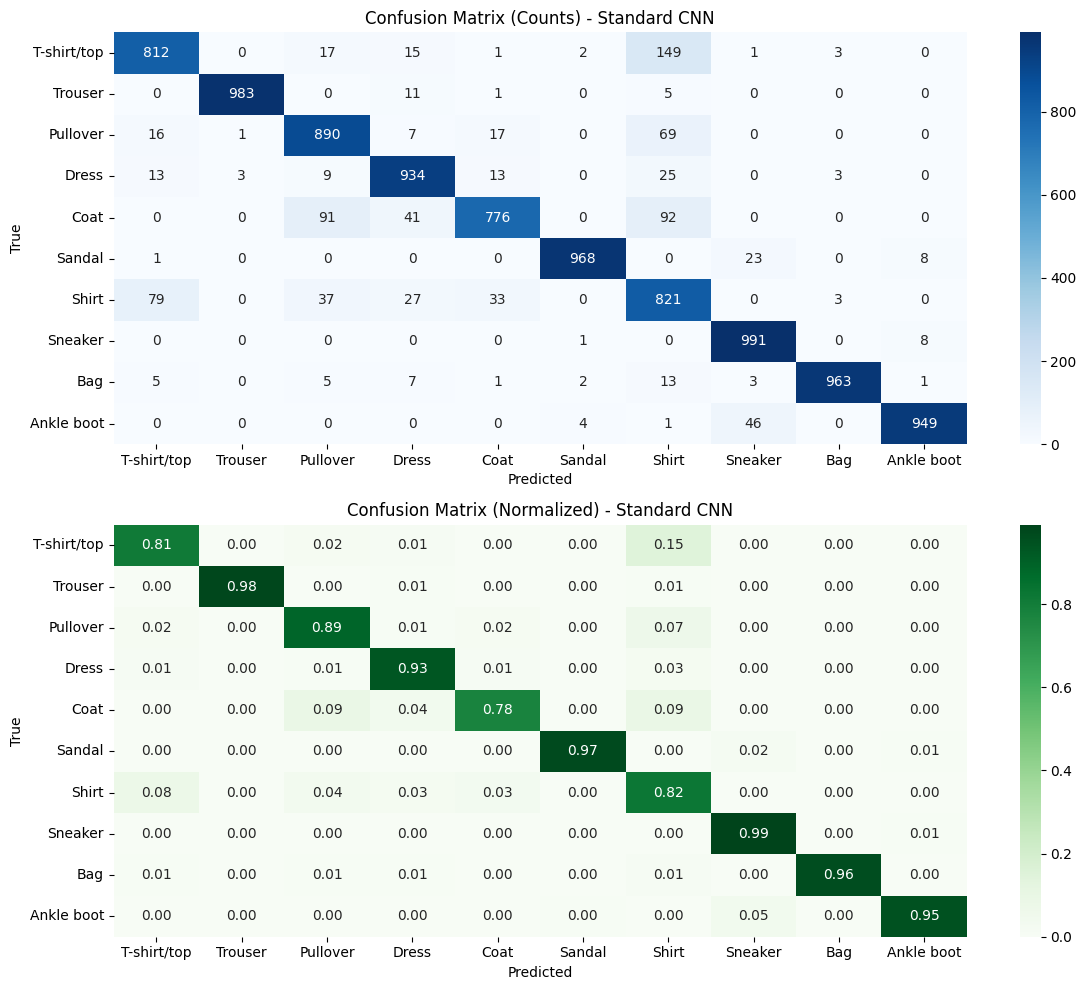

Classification Report for Standard CNN:

              precision    recall  f1-score   support

 T-shirt/top       0.88      0.81      0.84      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.85      0.89      0.87      1000
       Dress       0.90      0.93      0.91      1000
        Coat       0.92      0.78      0.84      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.70      0.82      0.75      1000
     Sneaker       0.93      0.99      0.96      1000
         Bag       0.99      0.96      0.98      1000
  Ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [54]:
plot_confusion_matrix_enhanced(standard_model, test_loader, "Standard CNN")

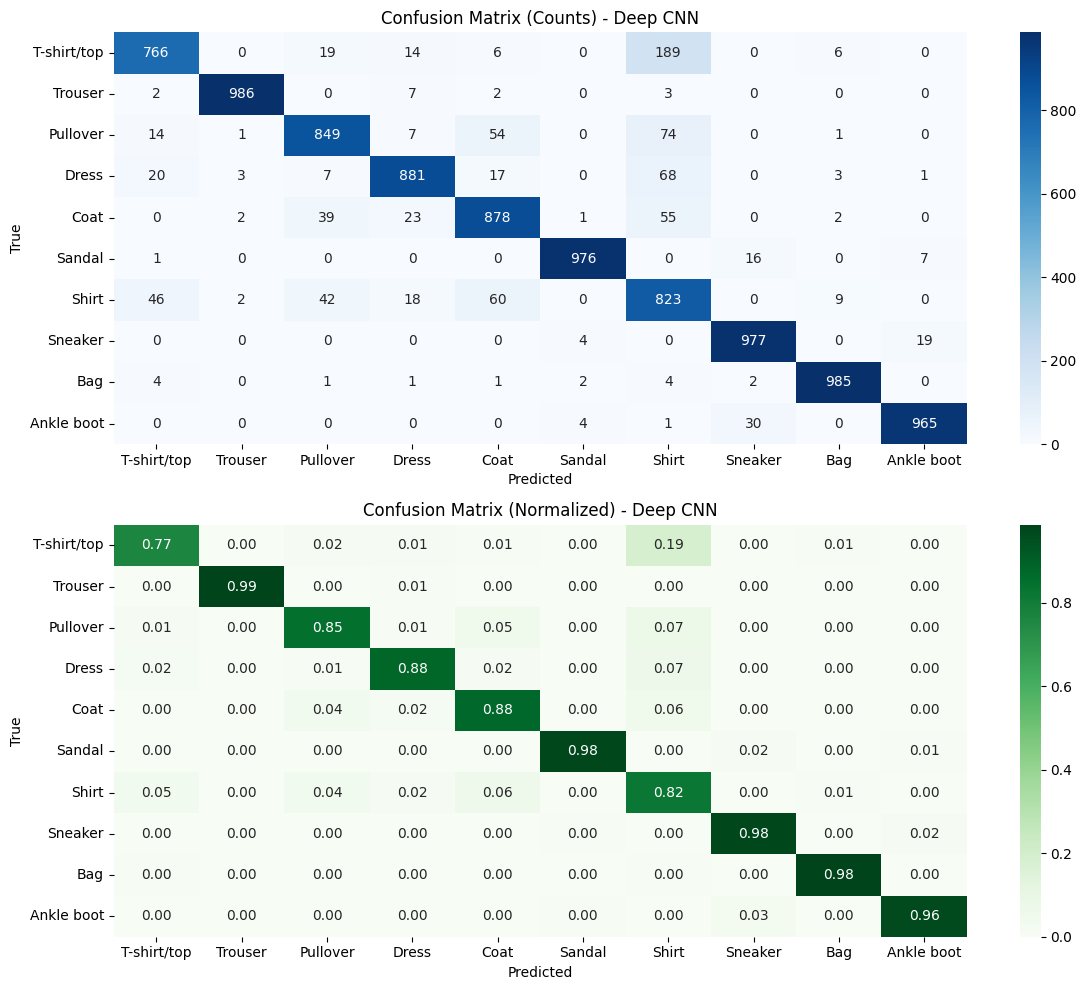

Classification Report for Deep CNN:

              precision    recall  f1-score   support

 T-shirt/top       0.90      0.77      0.83      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.89      0.85      0.87      1000
       Dress       0.93      0.88      0.90      1000
        Coat       0.86      0.88      0.87      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.68      0.82      0.74      1000
     Sneaker       0.95      0.98      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [55]:
plot_confusion_matrix_enhanced(deep_model, test_loader, "Deep CNN")

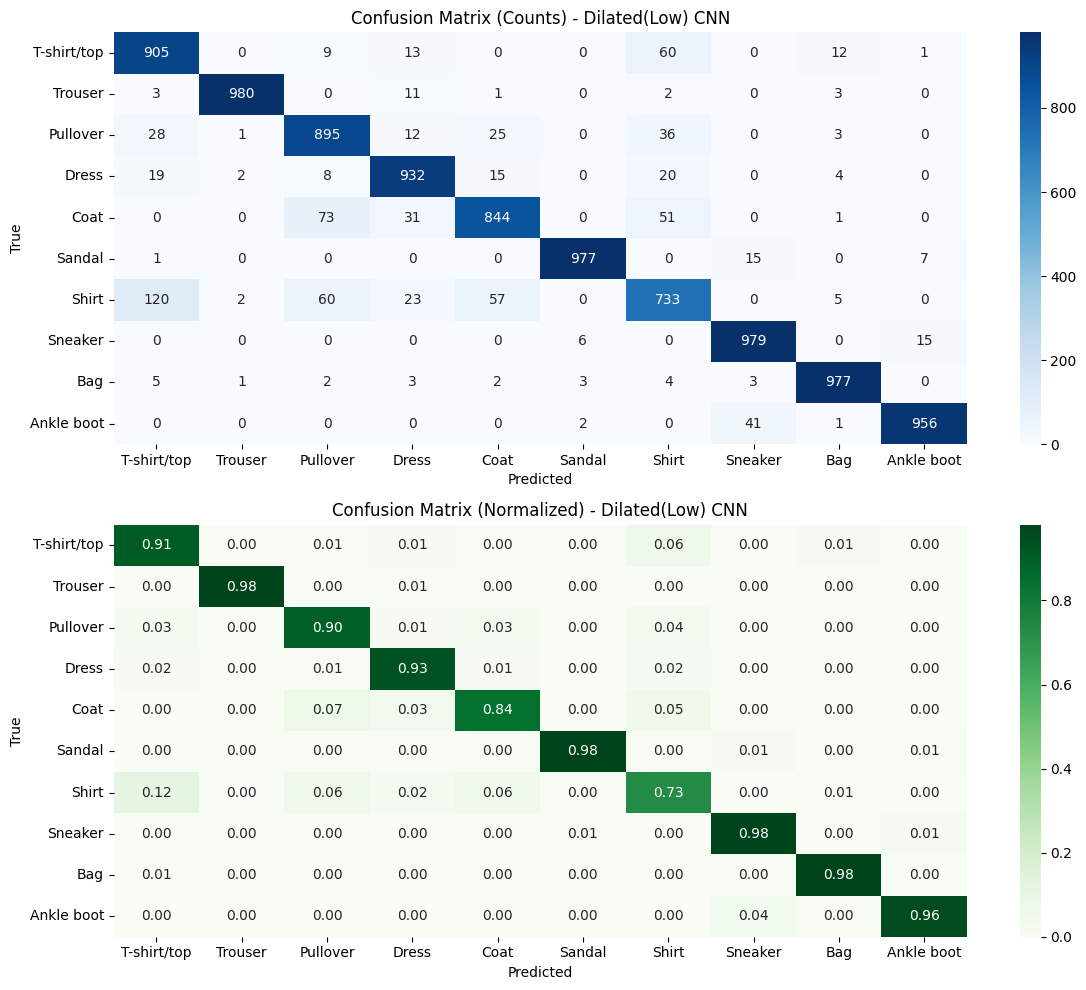

Classification Report for Dilated(Low) CNN:

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.91      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.85      0.90      0.87      1000
       Dress       0.91      0.93      0.92      1000
        Coat       0.89      0.84      0.87      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.81      0.73      0.77      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.97      0.98      0.97      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [56]:
plot_confusion_matrix_enhanced(dilated_low_model, test_loader, "Dilated(Low) CNN")

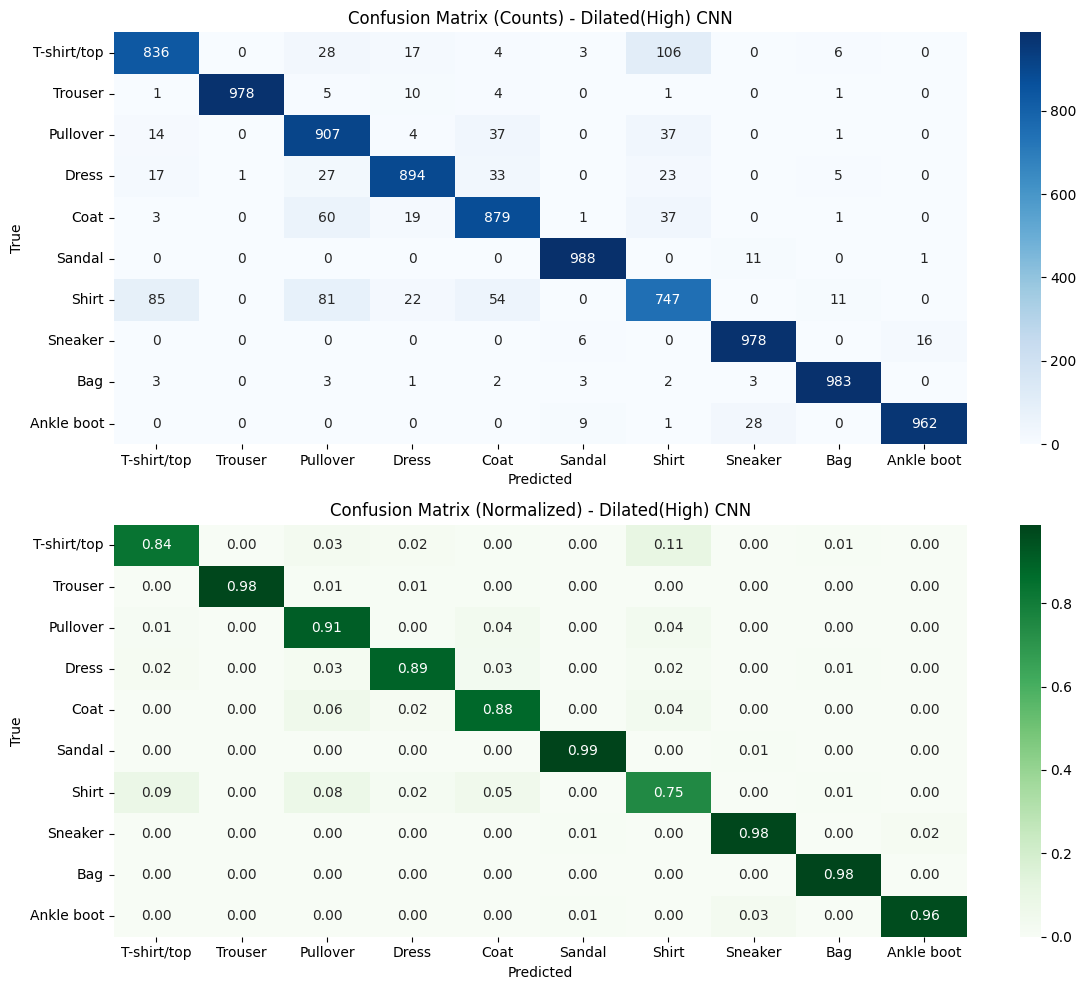

Classification Report for Dilated(High) CNN:

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.84      0.85      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.82      0.91      0.86      1000
       Dress       0.92      0.89      0.91      1000
        Coat       0.87      0.88      0.87      1000
      Sandal       0.98      0.99      0.98      1000
       Shirt       0.78      0.75      0.76      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [57]:
plot_confusion_matrix_enhanced(dilated_high_model, test_loader, "Dilated(High) CNN")

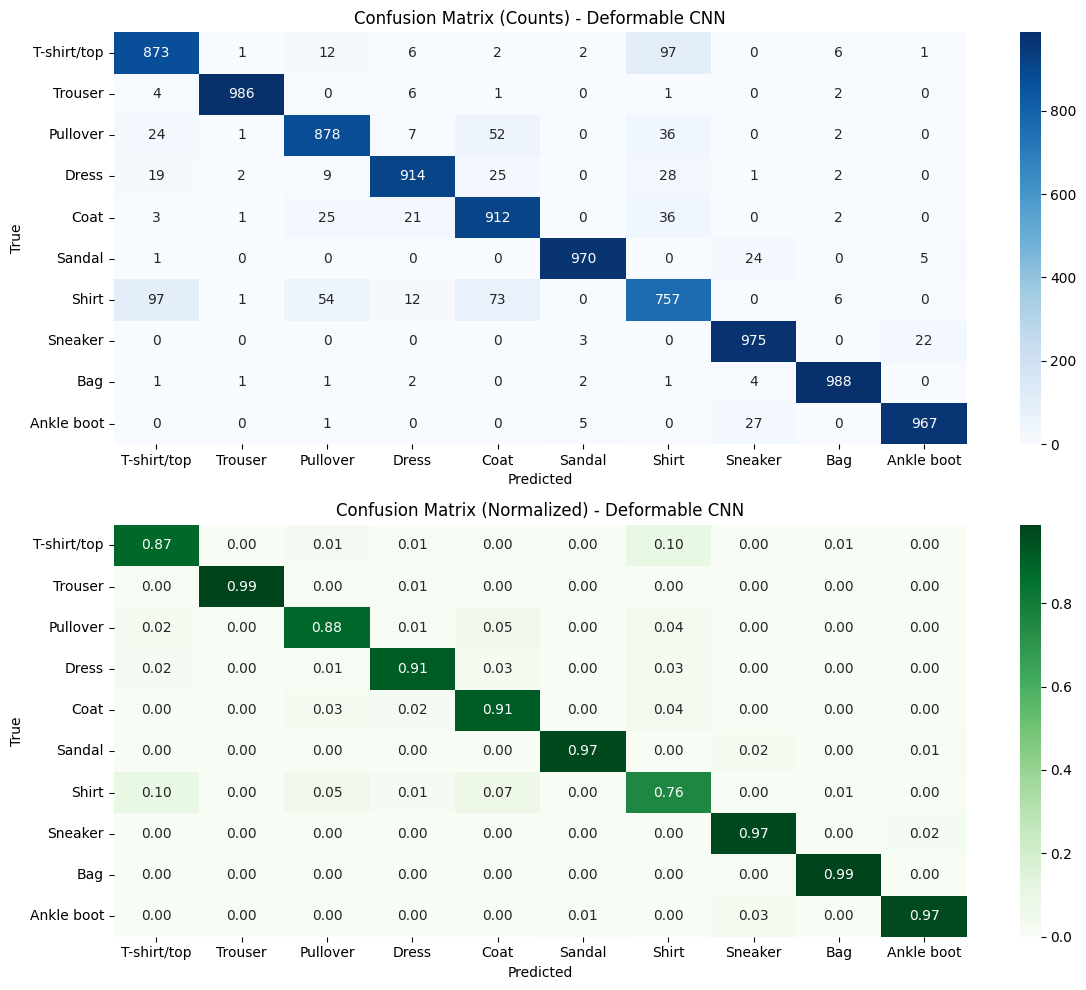

Classification Report for Deformable CNN:

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.87      0.86      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.90      0.88      0.89      1000
       Dress       0.94      0.91      0.93      1000
        Coat       0.86      0.91      0.88      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.79      0.76      0.77      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.98      0.99      0.98      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [58]:
plot_confusion_matrix_enhanced(deform_model, test_loader, "Deformable CNN")

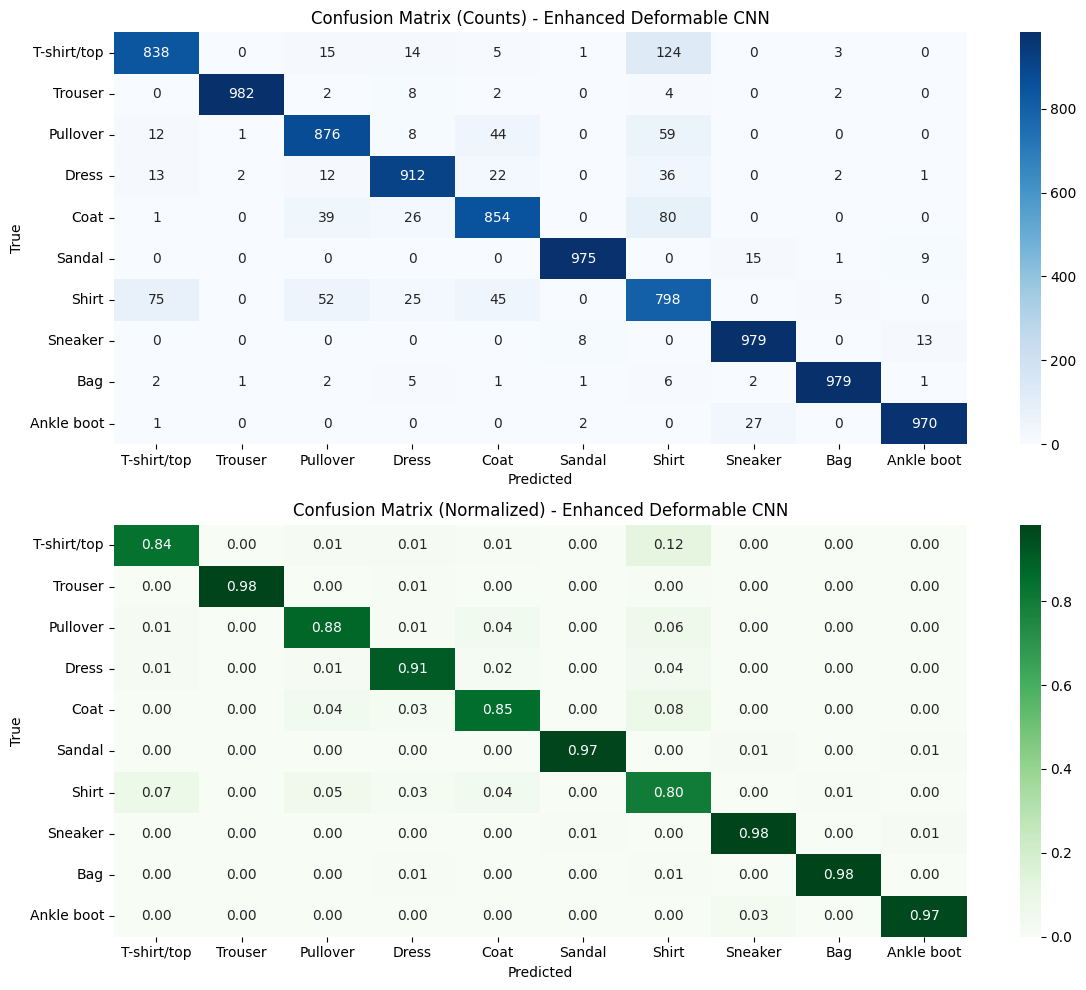

Classification Report for Enhanced Deformable CNN:

              precision    recall  f1-score   support

 T-shirt/top       0.89      0.84      0.86      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.88      0.88      0.88      1000
       Dress       0.91      0.91      0.91      1000
        Coat       0.88      0.85      0.87      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.72      0.80      0.76      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.98      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [59]:
plot_confusion_matrix_enhanced(enhanced_deform_model, test_loader, "Enhanced Deformable CNN")

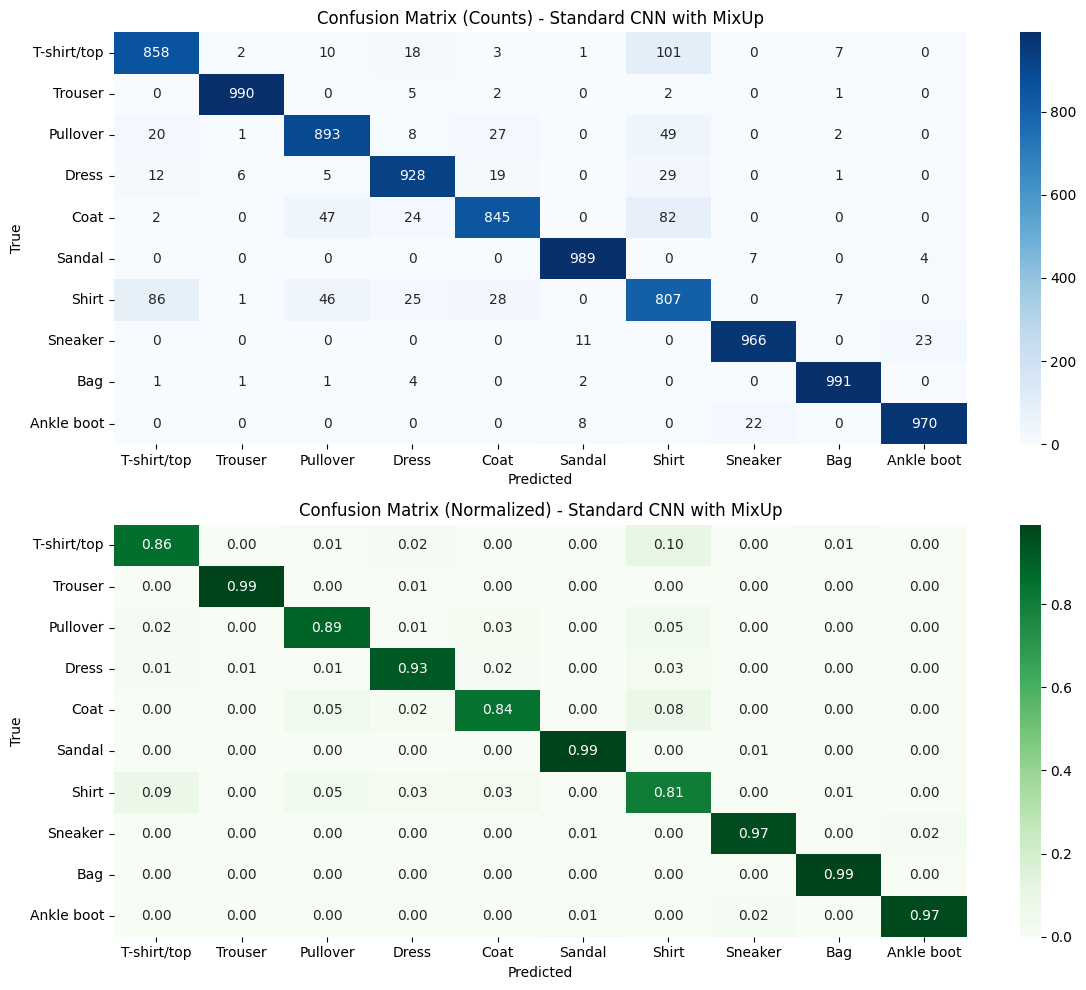

Classification Report for Standard CNN with MixUp:

              precision    recall  f1-score   support

 T-shirt/top       0.88      0.86      0.87      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.89      0.89      0.89      1000
       Dress       0.92      0.93      0.92      1000
        Coat       0.91      0.84      0.88      1000
      Sandal       0.98      0.99      0.98      1000
       Shirt       0.75      0.81      0.78      1000
     Sneaker       0.97      0.97      0.97      1000
         Bag       0.98      0.99      0.99      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [60]:
plot_confusion_matrix_enhanced(mixup_standard_model, test_loader, "Standard CNN with MixUp")

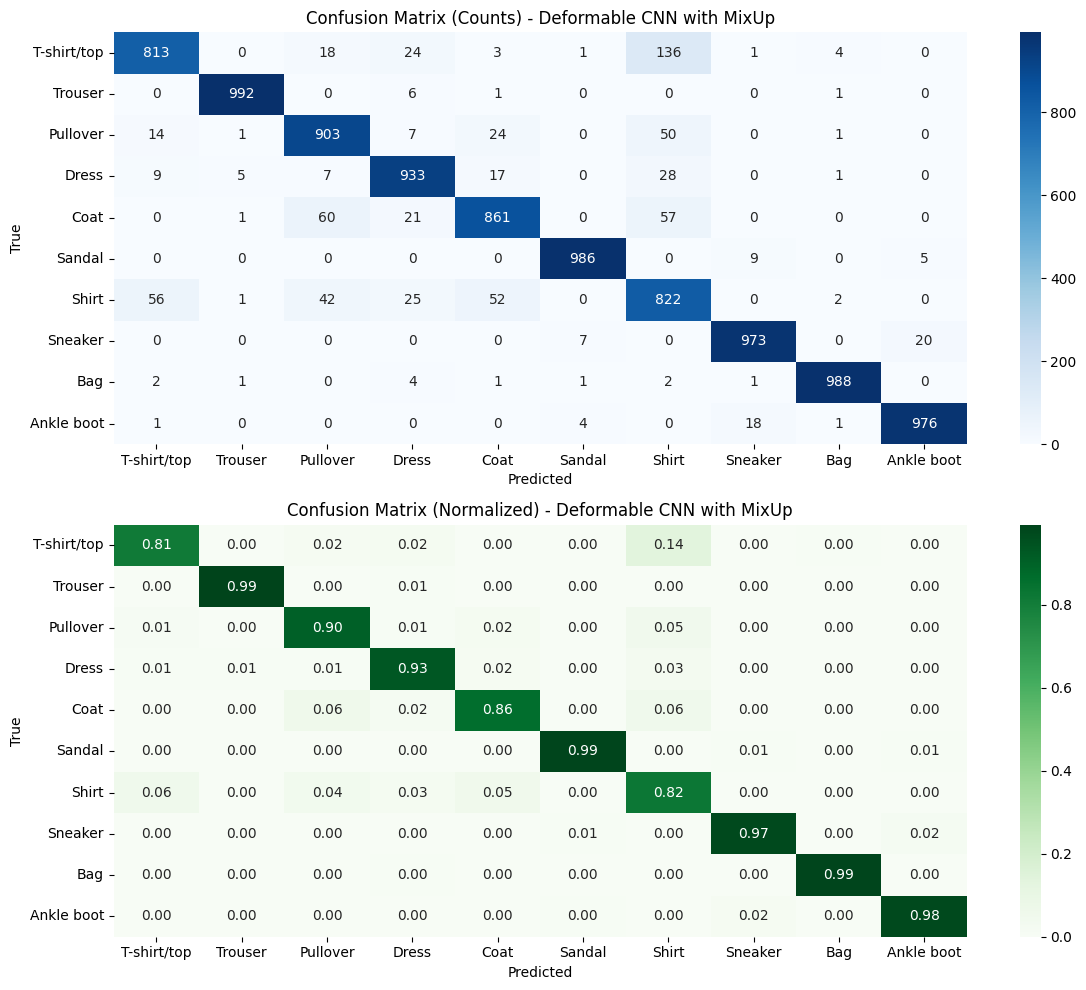

Classification Report for Deformable CNN with MixUp:

              precision    recall  f1-score   support

 T-shirt/top       0.91      0.81      0.86      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.88      0.90      0.89      1000
       Dress       0.91      0.93      0.92      1000
        Coat       0.90      0.86      0.88      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.75      0.82      0.78      1000
     Sneaker       0.97      0.97      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.98      0.98      1000

    accuracy                           0.92     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.92      0.92     10000



In [66]:
plot_confusion_matrix_enhanced(mixup_deform_model, test_loader, "Deformable CNN with MixUp")